In [1]:
import json
with open('prompt1.json', 'r') as file:
    openai_resp = json.load(file)

In [22]:
import pandas as pd
openai_resp=pd.DataFrame(openai_resp)

In [23]:
openai_resp

,openai_resp,index,label,language
0,50,0,false,tr
1,50,1,partly true/misleading,ka
2,50,2,partly true/misleading,pt
3,50,3,true,ka
4,50,4,false,id
...,...,...,...,...
994,50,994,true,ro
995,85,995,partly true/misleading,ar
996,0,996,partly true/misleading,ta
997,50,997,false,pt


In [24]:
#remove other and complicated labels 
df_results0 = openai_resp[~openai_resp['label'].isin(['complicated/hard to categorise', 'other'])]


In [25]:
# df_results0 = openai_resp.reset_index()
df_results0

,openai_resp,index,label,language
0,50,0,false,tr
1,50,1,partly true/misleading,ka
2,50,2,partly true/misleading,pt
3,50,3,true,ka
4,50,4,false,id
...,...,...,...,...
994,50,994,true,ro
995,85,995,partly true/misleading,ar
996,0,996,partly true/misleading,ta
997,50,997,false,pt


In [11]:
from sklearn.metrics import classification_report

In [72]:
import numpy as np
def gpt_tv(row):
    resp = row['openai_resp']
    try:
        resp = float(resp)
    except ValueError:
        return "unknown"
    
    if resp > 50: #TODO: tune this value?
        return 1
    
    else:
        return 0

def conservative_true_row(row):
    label = row['label']
    if label=="true":
        return 1
    else:
        return 0    

df_results0['openai_simple'] = df_results0.apply(gpt_tv, axis=1)
df_results0['simple_truth'] = df_results0.apply(conservative_true_row, axis=1)

# print(df_results0.shape)
df_processed = df_results0.copy().drop(df_results0[(df_results0.openai_simple != 0) & (df_results0.openai_simple != 1)].index)
df_processed = df_processed.drop(df_processed[df_processed.label.isin(['complicated/hard to categorise', 'other', np.nan])].index)
df_processed = df_processed.reset_index()

In [80]:
print(classification_report(df_processed['simple_truth'].values.tolist(), df_processed['openai_simple'].values.tolist()))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       739
           1       0.51      0.28      0.36       204

    accuracy                           0.79       943
   macro avg       0.67      0.60      0.62       943
weighted avg       0.76      0.79      0.76       943



In [33]:
def euro_or_not(lang):
    if lang in ["de", "es", "fr", "it", "no", "nl", "pl", "pt", "ro", "ru", "sr", "sq"]: #german, spanish, french, italian, norwegian, dutch, polish
        return True
    else: #ar - arabic; az - azerbaijani; bn - bengali; fa - farsi; gu - gujarati; hi - hindi; id - indonesian
        #ka - georgian; mr - marathi; pa - punjabi; si - sinhala; ta - tamil; tr - turkish
        return False

In [34]:
def conservative_true(label):
    if label=="true":
        return 1
    else:
        return 0

In [35]:
df_x_fact = pd.read_csv("../data/x_fact_dataset/x-fact-including-en/train.all.tsv", delimiter="\t", on_bad_lines="skip")

In [52]:
euro_y_true = []
euro_y_pred = []
non_euro_y_true = []
non_euro_y_pred = []
for i in range(df_processed.shape[0]):
    init_index = df_processed['index'][i]
    if df_processed['label'][i]!=df_x_fact['label'][init_index]:
        print(i, init_index)
    if euro_or_not(df_x_fact['language'][init_index]):
        euro_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        euro_y_pred.append(df_processed['openai_simple'][i])
    else:
        non_euro_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        non_euro_y_pred.append(df_processed['openai_simple'][i])

In [53]:
print(classification_report(euro_y_true, euro_y_pred))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       370
           1       0.55      0.29      0.38       143

    accuracy                           0.73       513
   macro avg       0.66      0.60      0.61       513
weighted avg       0.71      0.73      0.71       513



In [54]:
print(classification_report(non_euro_y_true, non_euro_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       369
           1       0.44      0.25      0.32        61

    accuracy                           0.85       430
   macro avg       0.66      0.60      0.62       430
weighted avg       0.82      0.85      0.83       430



In [40]:
def western(lang):
    if lang in ["de", "es", "fr", "it", "nl", "no", "pt"]:
        return True
    else:
        return False

In [55]:
western_y_true = []
western_y_pred = []
non_western_y_true = []
non_western_y_pred = []
for i in range(df_processed.shape[0]):
    init_index = df_processed['index'][i]
    if df_processed['label'][i]!=df_x_fact['label'][init_index]:
        print(i, init_index)
    if western(df_x_fact['language'][init_index]):
        western_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        western_y_pred.append(df_processed['openai_simple'][i])
    else:
        non_western_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        non_western_y_pred.append(df_processed['openai_simple'][i])

In [56]:
print(classification_report(western_y_true, western_y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       292
           1       0.52      0.29      0.37        94

    accuracy                           0.76       386
   macro avg       0.66      0.60      0.61       386
weighted avg       0.73      0.76      0.74       386



In [57]:
print(classification_report(non_western_y_true, non_western_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88       447
           1       0.51      0.27      0.36       110

    accuracy                           0.80       557
   macro avg       0.67      0.60      0.62       557
weighted avg       0.77      0.80      0.78       557



In [47]:
def small(lang):
    if lang in ["no", "nl", "pl", "ro", "sr", "sq", "az", "ka", "si"]:
        return True
    else: return False

In [58]:
small_y_true = []
small_y_pred = []
large_y_true = []
large_y_pred = []
for i in range(df_processed.shape[0]):
    # if df_results0['cohere_simple'][i] not in [0,1]:
    #     continue
    init_index = df_processed['index'][i]
    if df_processed['label'][i]!=df_x_fact['label'][init_index]:
        print(i, init_index)
    if small(df_x_fact['language'][init_index]):
        small_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        small_y_pred.append(df_processed['openai_simple'][i])
    else:
        large_y_true.append(conservative_true(df_x_fact['label'][init_index]))
        large_y_pred.append(df_processed['openai_simple'][i])

In [59]:
print(classification_report(small_y_true, small_y_pred))

              precision    recall  f1-score   support

           0       0.68      0.91      0.78       134
           1       0.59      0.23      0.33        74

    accuracy                           0.67       208
   macro avg       0.63      0.57      0.55       208
weighted avg       0.65      0.67      0.62       208



In [60]:
print(classification_report(large_y_true, large_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       605
           1       0.49      0.31      0.38       130

    accuracy                           0.82       735
   macro avg       0.67      0.62      0.64       735
weighted avg       0.80      0.82      0.80       735



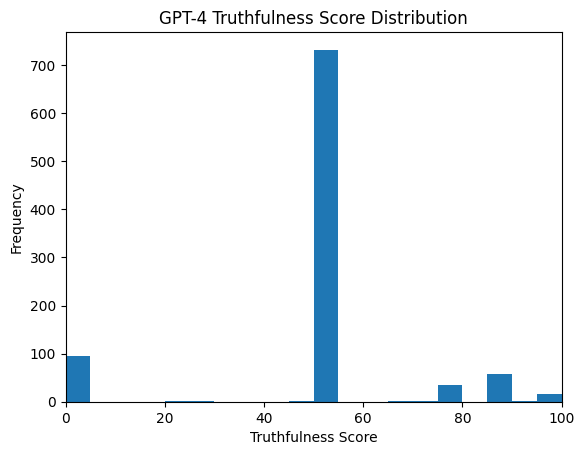

In [79]:
import matplotlib.pyplot as plt
plt.hist(df_processed['openai_resp'].map(float).values,bins=20)
plt.title("GPT-4 Truthfulness Score Distribution")
plt.xlim(0,100)
plt.ylabel("Frequency")
# plt.yscale('log')
plt.xlabel("Truthfulness Score")
plt.show()